# Importing Libraries

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
# from torchsummary import summary
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as trans
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
import random

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
#for cuda
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
os.chdir('/content/drive/MyDrive/ECG Project')

In [ ]:
! ls

 Data				   'EcG PPT'	   Image_Test
 Data1				   'IEEE Papers'   models
 EcGDemo.ipynb			    Image2k	  'signal to image.ipynb'
'ECG IMAGE Training Results.gdoc'   Image_test


# Dataset

In [ ]:
train_path = '/content/drive/MyDrive/ECG Project/Image2k'
test_path = '/content/drive/MyDrive/ECG Project/Image_Test'

In [ ]:
transform = trans.Compose([
    trans.Resize((280,300)), 
    trans.CenterCrop((224,224)),
    trans.ToTensor(),
    trans.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [ ]:
Train_dataset_1 = datasets.ImageFolder(train_path, transform=transform)
Train_dataset_2 = datasets.ImageFolder(train_path, transform=transform)
test_set = datasets.ImageFolder(test_path, transform=transform)

In [ ]:
len(Train_dataset_1), len(Train_dataset_2), len(test_set)

(10000, 10000, 3718)

In [ ]:
#First, we will split the image indices into two groups
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(Train_dataset_1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

8000
----------
2000


In [ ]:
from torch.utils.data import Subset #Subset of a dataset at specified indices

train_set=Subset(Train_dataset_1,train_index)
print(len(train_set))

val_set=Subset(Train_dataset_2,val_index)
print(len(val_set))

8000
2000


In [ ]:
batch_size = 16
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)
val_dl = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False,  num_workers=8)

In [ ]:
data_dl = DataLoader(train_set, batch_size=4, shuffle=False, drop_last=False)

In [ ]:
classes = ['0','1','2','3','4']
num_classes = len(classes)

In [ ]:
def imshow(img):
    
    std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    npimg = np.multiply(img.numpy(), std_correction) + mean_correction
    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
dataiter=iter(data_dl)
images,labels=dataiter.next()

print(images.shape,labels.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224]) torch.Size([4])
torch.Size([3, 224, 224])
4


In [ ]:
labels.shape

torch.Size([4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


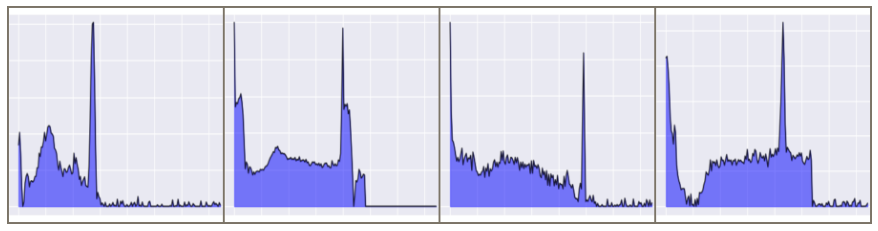

3     4     1     2


In [ ]:
imshow(torchvision.utils.make_grid(images))
print('     '.join(classes[labels[j]] for j in range(4)))

# Model

In [ ]:
resnet=models.resnet34(pretrained=False)

In [ ]:
# print(resnet)

In [ ]:
resnet.fc.out_features = num_classes

In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training

In [ ]:
resnet=resnet.to(device)
loss_func=nn.CrossEntropyLoss() 
opt = optim.Adam(resnet.parameters())

In [ ]:
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=3,verbose=1)

In [ ]:
def evaluation(dataloader,model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    return 100 * correct / total

In [ ]:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item()

In [ ]:
import copy
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.001


In [ ]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    len_batch=len(dataset_dl)

    for xb, yb in tqdm(dataset_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        
        output=model(xb)
        loss_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b

        if sanity_check is True:
            break
        del(loss_b)
    loss=running_loss/float(len_batch)
    del(running_loss)
    return loss

In [ ]:
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    acc_history={
        "train": [],
        "val": []}
     
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    best_error = 100
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss = loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        train_acc = evaluation(train_dl, model)
        acc_history['train'].append(train_acc)
        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model,loss_func,val_dl,sanity_check)
            val_acc = evaluation(val_dl, model)
        loss_history["val"].append(val_loss)
        acc_history['val'].append(val_acc)
        
        # if val_loss < best_loss:
        #     best_loss = val_loss
        #     best_model_wts = copy.deepcopy(model.state_dict())
            
        #     torch.save(model.state_dict(), path2weights)
        #     print("Copied best model weights!")
        if (100-val_acc) < best_error:
            best_error = 100-val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(100-val_acc)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        print("train loss: %.6f" %(train_loss))
        print("val loss: %.6f" %(val_loss))
        # print('\n')
        print("train acc: %.6f" %(train_acc))
        print("val acc: %.6f" %(val_acc))
        print("-"*10) 
        torch.cuda.empty_cache()

    model.load_state_dict(best_model_wts)
    return model, loss_history , acc_history 


In [ ]:
path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

In [ ]:
params_train={
    "num_epochs": 12,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"resnet34.pt",
}


In [ ]:
model,loss_hist, acc_hist = train_val(resnet,params_train)

Epoch 0/11, current lr=0.001



Copied best model weights!
train loss: 0.636906
val loss: 0.414912
train acc: 85.375000
val acc: 83.800000
----------
Epoch 1/11, current lr=0.001



Copied best model weights!
train loss: 0.411978
val loss: 0.332647
train acc: 88.987500
val acc: 88.300000
----------
Epoch 2/11, current lr=0.001



Copied best model weights!
train loss: 0.351777
val loss: 0.285736
train acc: 90.600000
val acc: 88.850000
----------
Epoch 3/11, current lr=0.001



train loss: 0.275129
val loss: 0.388701
train acc: 85.737500
val acc: 85.000000
----------
Epoch 4/11, current lr=0.001



Copied best model weights!
train loss: 0.256727
val loss: 0.256304
train acc: 92.712500
val acc: 91.500000
----------
Epoch 5/11, current lr=0.001



Copied best model weights!
train loss: 0.207134
val loss: 0.238594
train acc: 93.950000
val acc: 91.550000
----------
Epoch 6/11, current lr=0.001



Copied best model weights!
train loss: 0.196042
val loss: 0.238860
train acc: 94.412500
val acc: 91.600000
----------
Epoch 7/11, current lr=0.001



Copied best model weights!
train loss: 0.169303
val loss: 0.202919
train acc: 96.187500
val acc: 92.750000
----------
Epoch 8/11, current lr=0.001



Copied best model weights!
train loss: 0.152036
val loss: 0.209626
train acc: 96.925000
val acc: 93.050000
----------
Epoch 9/11, current lr=0.001



Copied best model weights!
train loss: 0.131716
val loss: 0.201131
train acc: 96.700000
val acc: 93.250000
----------
Epoch 10/11, current lr=0.001



train loss: 0.103205
val loss: 0.239017
train acc: 97.287500
val acc: 93.000000
----------
Epoch 11/11, current lr=0.001



Copied best model weights!
train loss: 0.102593
val loss: 0.212041
train acc: 97.387500
val acc: 93.550000
----------


# Results

In [ ]:
import seaborn as sns
sns.set()

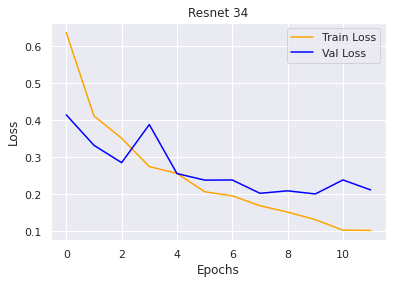

In [ ]:
plt.figure(facecolor='white')
plt.title("Resnet 34")
plt.plot(loss_hist['train'],c='orange', label = 'Train Loss')
plt.plot(loss_hist['val'],c = 'blue', label = 'Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

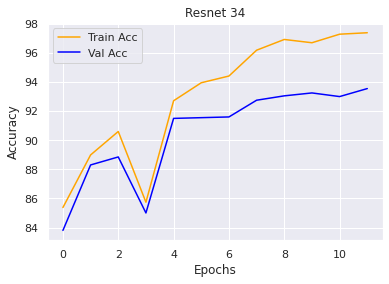

In [ ]:
plt.figure(facecolor='white')
plt.title("Resnet 34")
plt.plot(acc_hist['train'],c='orange', label = 'Train Acc')
plt.plot(acc_hist['val'],c = 'blue', label = 'Val Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Confusion Matrix

In [ ]:
model.eval()

In [ ]:
nb_classes = num_classes

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_dl):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[336.,  19.,   7.,   9.,   2.],
        [ 29., 358.,   7.,   4.,   0.],
        [ 11.,   5., 394.,   7.,   2.],
        [  9.,   0.,   7., 382.,   0.],
        [  4.,   4.,   3.,   0., 401.]])


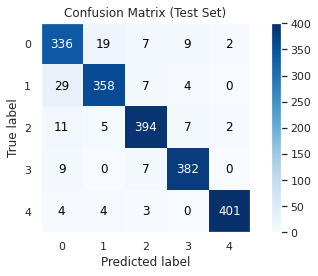

In [ ]:
classes = np.arange(num_classes)
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(confusion_matrix.shape[1]),
            yticks=np.arange(confusion_matrix.shape[0]),
            xticklabels=classes, yticklabels=classes,
            ylabel='True label',
            xlabel='Predicted label',
            title='Confusion Matrix (Test Set)',
            )
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, int(confusion_matrix[i, j]),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")
plt.grid(b=None)
fig.tight_layout()

In [ ]:
def evaluation_test(dataloader,model):
    total, correct = 0, 0
    for data in tqdm(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    return 100 * correct / total

In [ ]:
test_acc = evaluation_test(test_dl,model)
print("Test Acc: ",test_acc)


Test Acc:  93.57181280258203


#Loading and inference

In [ ]:
import skimage.transform

In [ ]:
path2models+"resnet34.pt"

'./models/resnet34.pt'

In [ ]:
model_path = './models/resnet34.pt'
num_classes = 5

In [ ]:
model = models.resnet34()
model.fc.out_features = num_classes

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model.eval()

In [ ]:
test_folders = glob.glob(test_path+'/*')

In [ ]:
test_folders

['/content/drive/MyDrive/ECG Project/Image_Test/0',
 '/content/drive/MyDrive/ECG Project/Image_Test/1',
 '/content/drive/MyDrive/ECG Project/Image_Test/2',
 '/content/drive/MyDrive/ECG Project/Image_Test/3',
 '/content/drive/MyDrive/ECG Project/Image_Test/4']

In [ ]:
c = 0
folder = test_folders[c]
imgs = glob.glob(folder+'/*')
img_path = random.choice(imgs)
img_path

'/content/drive/MyDrive/ECG Project/Image_Test/0/379_0.png'

In [ ]:
class SaveActivations():
    activations=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.data
    def remove(self):
        self.hook.remove()


In [ ]:
preprocess = trans.Compose([
    trans.Resize((280,300)), 
    trans.CenterCrop((224,224)),
    trans.ToTensor(),
    trans.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
display_transform = trans.Compose([
    trans.Resize((280,300)), 
    trans.CenterCrop((224,224))
    ])

In [ ]:
label = img_path[-5]
print(label)
img = Image.open(img_path).convert('RGB')

0


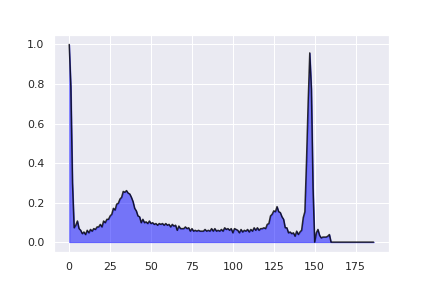

In [ ]:
img

In [ ]:
img_tensor = preprocess(img)
print(img_tensor.shape)
img_activations = SaveActivations(model.layer4)
prediction = model(img_tensor.unsqueeze(0))
pred_probabilities = F.softmax(prediction).data.squeeze()
img_activations.remove()
torch.topk(pred_probabilities,1)

torch.Size([3, 224, 224])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


torch.return_types.topk(values=tensor([0.9968]), indices=tensor([0]))

In [ ]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [ ]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [ ]:
class_idx = torch.topk(pred_probabilities,1)[1].int()

In [ ]:
overlay = getCAM(img_activations.features, weight_softmax, class_idx )

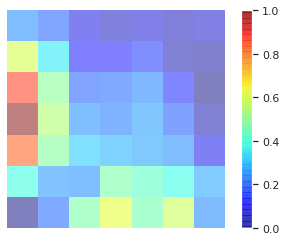

In [ ]:
plt.imshow(overlay[0], alpha=0.5, cmap='jet')
plt.colorbar();
plt.grid('False')
plt.axis('off');

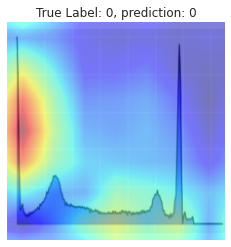

In [ ]:
plt.imshow(display_transform(img))
plt.imshow(skimage.transform.resize(overlay[0], img_tensor.shape[1:3]), alpha=0.5, cmap='jet');
plt.title(f"True Label: {label}, prediction: {str(class_idx.item())}")
plt.grid('False')
plt.axis('off');

In [ ]:
def cam(c):
    folder = test_folders[c]
    imgs = glob.glob(folder+'/*')
    img_path = random.choice(imgs)
    label = img_path[-5]
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img)
    img_activations = SaveActivations(model.layer4)
    prediction = model(img_tensor.unsqueeze(0))
    pred_probabilities = F.softmax(prediction,1).data.squeeze()
    img_activations.remove()
    prob = torch.topk(pred_probabilities,1)[0].item()
    weight_softmax_params = list(model._modules.get('fc').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
    class_idx = torch.topk(pred_probabilities,1)[1].int().item()
    overlay = getCAM(img_activations.features, weight_softmax, class_idx )
    plt.imshow(display_transform(img))
    plt.imshow(skimage.transform.resize(overlay[0], img_tensor.shape[1:3]), alpha=0.5, cmap='jet');
    plt.title(f"True Label: {label}, prediction: {str(class_idx)}")
    plt.grid('False')
    plt.axis('off');
    print(f"Prediction Probability: {str(prob)[:4]}")
    plt.show()

Prediction Probability: 0.99


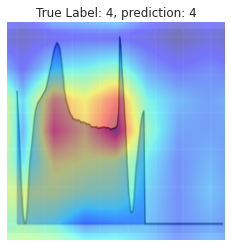

Prediction Probability: 1.0


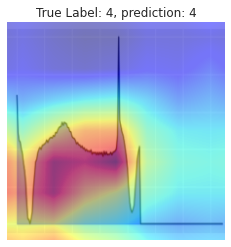

Prediction Probability: 1.0


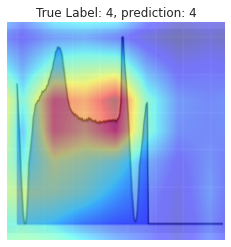

Prediction Probability: 1.0


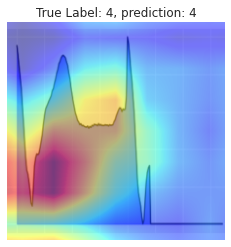

Prediction Probability: 0.99


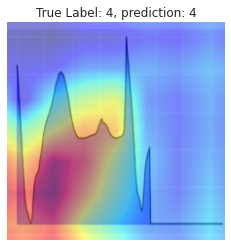

In [ ]:
# cam(c = random.choice([0,1,2,3,4]))
for i in range(5):
    cam(c=4)